In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

#Import libraries for plotting confusion metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Import library for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

#Import library for validation 
from sklearn.model_selection import validation_curve

%matplotlib inline


In [2]:
#Read the data file and drop garbage columns
dt = pd.read_csv('cardiotocography.csv')
dt = dt.drop(['Unnamed: 23','CLASS'],axis = 1)
dt.iloc[:,10:22].describe()

,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [3]:
dt['Tendency'][dt['Tendency'] == -1] = 'left_asymmetric'
dt['Tendency'][dt['Tendency'] == 0] = 'symmetric'
dt['Tendency'][dt['Tendency'] == 1] = 'right_asymmetric'

dt['Tendency'] = dt['Tendency'].astype('object')

dt = pd.get_dummies(dt, drop_first=False)
dt.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency_left_asymmetric,Tendency_right_asymmetric,Tendency_symmetric
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,2,0,120,137,121,73,2,0,1,0
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,6,1,141,136,140,12,1,0,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,5,1,141,135,138,13,1,0,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,11,0,137,134,137,13,1,0,1,0
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,9,0,137,136,138,11,1,0,1,0


In [4]:
X= dt.drop('NSP', 1)
y = dt['NSP'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=10) #split the data


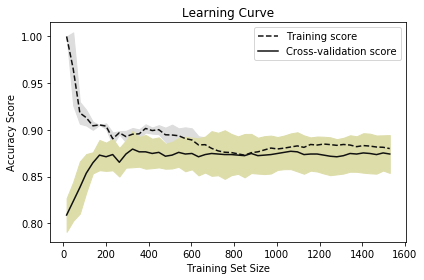

In [13]:
#plotting the learning curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDAA")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

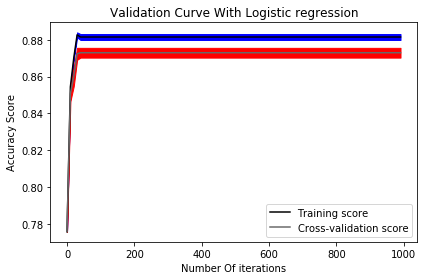

In [5]:
#Learn the hyperparameter maximum iterations 
param_range = np.arange(0, 1000, 10 )

train_scores, test_scores = validation_curve(LogisticRegression(), X_train, y_train, param_name = "max_iter",param_range = param_range
                ,scoring = 'accuracy',n_jobs=-1)
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - (train_std/3), train_mean + (train_std/3), color="blue")
plt.fill_between(param_range, test_mean - (test_std/3), test_mean + (test_std/3), color="red")

# Create plot
plt.title("Validation Curve With Logistic regression")
plt.xlabel("Number Of iterations")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [6]:
model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
#Fit the model
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
#Make predictions
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

0.9107981220657277
The precision recall, F1 score and support for each class
              precision    recall  f1-score   support

           1      0.929     0.976     0.952       336
           2      0.833     0.574     0.680        61
           3      0.806     0.862     0.833        29

    accuracy                          0.911       426
   macro avg      0.856     0.804     0.822       426
weighted avg      0.907     0.911     0.905       426



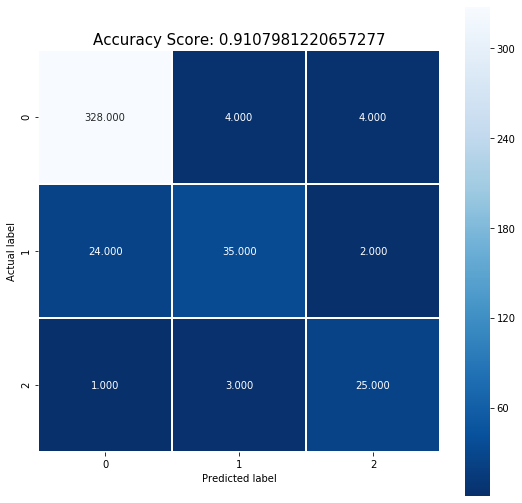

In [8]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print(score)

print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))
#Show the confusion matrix


#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);